# SOCRATES Comparison of single column vs Dynamical
This looks at the effect of circulation on the location and time of the hottest day. It does this by comparing two no-WISHE simulations with vs without dynamics (no dynamics is single column simulation).

In [1]:
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure, partial_pressure_from_sphum
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v, g
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity, opd_lw_gray
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import cftime
import calendar
from datetime import timedelta
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def shift_time(ds):
    # Make 1st time year 1, day 1, month 1
    # Assume `ds` is your dataset
    n_times = ds.time.size

    # Create new time array starting at year 1, day 1, 12:00 using 360_day calendar
    new_time = [cftime.Datetime360Day(1, 1, 1, 12) + timedelta(days=i) for i in range(n_times)]

    # Assign new time coordinate
    ds['time'] = ('time', new_time)
    return ds

def get_temp_rad(lwdn_sfc, opd):
    # Returns radiative temperature, T_r, such that LW_down = sigma T_r^4 (1 - e^{-opd})
    emission_factor = 1 - np.exp(-opd)
    return (lwdn_sfc / emission_factor / Stefan_Boltzmann)**0.25

In [307]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'ps', 'precipitation', 'flux_lhe', 'flux_t', 'lwdn_sfc', 'lwup_sfc', 'swdn_sfc']

# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'ps', 'precipitation', 'flux_lhe', 'flux_t']
var_keep += ['soc_toa_sw_down', 'soc_surf_flux_sw_down', 'soc_surf_flux_sw',
             'soc_surf_flux_lw_down', 'soc_surf_flux_lw', 'soc_coszen']

def rename_ds_soc(ds):
    # Rename socrates dataset to match names of gray
    ds['lwup_sfc'] = ds.soc_surf_flux_lw + ds.soc_surf_flux_lw_down
    return ds.rename({'soc_surf_flux_sw': 'swdn_sfc', 'soc_surf_flux_lw_down': 'lwdn_sfc', 'soc_toa_sw_down': 'swdn_toa'})

# # DEFAULT experiment
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/no_wishe/socrates/'
# exp_name = ['base' 'no_co2_col']
exp_name = ['base', 'no_co2']
# exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/'
# exp_name = ['base', 'no_wishe/base_col']
n_exp = len(exp_name)

# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
    drag_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['drag_const']
except KeyError:
    w_atm_const = None
    drag_const = None
evap_prefactor = []
for i in range(n_exp):
    try:
        evap_prefactor.append(isca_tools.load_namelist(exp_dir+exp_name[i])['surface_flux_nml']['land_evap_prefactor'])
    except KeyError:
        evap_prefactor.append(1)
land_h_capacity_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['mixed_layer_nml']['land_h_capacity_prefactor']
albedo = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['albedo_value'] for i in range(n_exp)]

n_exp = len(exp_name)
lat_range = slice(-40, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
# use_time_start = cftime.Datetime360Day(10, 1, 1)   # Year 10, January 1st
use_time_start = cftime.Datetime360Day(1, 1, 1)   # Year 1, January 1st
use_time_end = cftime.Datetime360Day(9000, 12, 30)  # Year 9000, December 30th (basically infinity)
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i], decode_times=True).isel(lon=0, drop=True)
    ds_use = ds_use[var_keep]
    ds_use = rename_ds_soc(ds_use)
    ds_use = ds_use.sel(time=slice(use_time_start, use_time_end)).sel(lat=lat_range)
    # ds_use['water_depth'] = get_water_column_depth(ds_use.sphum.transpose("pfull", "time", "lat"), ds_use.pfull.values*100)
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp**4)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
    ds_use['rh'] = ds_use.sphum / sphum_sat(ds_use.temp, ds_use.ps*sigma_near_surf)
    ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    ds_use['flux_sfc_dn_net'] = ds_use.swdn_sfc + ds_use.lwdn_sfc - ds_use.lwup_sfc - ds_use.flux_lhe - ds_use.flux_t

    ds_use = shift_time(ds_use)       # shift so first is year 1, month 1, day 1
    ds_base.append(ds_use.load())      # only keep after spin up
for i in range(1, n_exp):
    xr.testing.assert_identical(ds_base[0].time, ds_base[i].time)      # ensure times are the same
mixed_layer_depth = {'ocean': namelist['mixed_layer_nml']['depth']}
mixed_layer_depth['land'] = namelist['mixed_layer_nml']['land_h_capacity_prefactor'] * mixed_layer_depth['ocean']
p_lowlevel = float(ds_base[0].pfull*100)

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 181 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 181 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [308]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5, 'two_thirds': 4.5}        # width in inches
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_lat = [np.floor(ds_base[0].lat[0]), np.ceil(ds_base[0].lat[-1])]
ax_lims_time = [0, 360]

leg_info = {'handlelength': 1, 'labelspacing': 0.2, 'columnspacing': 0.9, 'handletextpad': 0.5}       # info for legend
def add_legend(ax, handles=None, labels=None, ncol=1, title=None, loc=None, frameon=False, edgecolor="k", borderpad=None,
               labelspacing=leg_info['labelspacing'], handlelength=leg_info['handlelength'],
               columnspacing=leg_info['columnspacing'], handletextpad=leg_info['handletextpad']):
    if handles is None:
        return ax.legend(ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                 labelspacing=labelspacing, handlelength=handlelength,
                 columnspacing=columnspacing, handletextpad=handletextpad)
    else:
        return ax.legend(handles, labels, ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                         labelspacing=labelspacing, handlelength=handlelength,
                         columnspacing=columnspacing, handletextpad=handletextpad)

In [309]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_name[0], 'land.nc')
# fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
# isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]  # get the latitude coordinates of land
lat_ocean = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[0]
lat_land_min = (lat_land.min() + lat_ocean.max()) / 2           # show land in plots as average between ocean and land extrema
lat_land_max = 90

# Add heat capacity to dataset
for i in range(n_exp):
    ds_base[i]['heat_capacity'] = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth['land'] *
                                                    (ds_base[i].lat > lat_land_min) + mixed_layer_depth['ocean'] *
                                                      (ds_base[i].lat < lat_land_min))
    # Record evaporative fraction as well
    ds_base[i]['evap_frac'] = (ds_base[i].lat > lat_land_min) * evap_prefactor[i] + (ds_base[i].lat < lat_land_min)

In [310]:
def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if not isinstance(ax, (list, np.ndarray)):
        raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
    for i in range(len(ax)):
        if lat_ax == 'x':
            var = ax[i].get_ylim()[0]
            xlim = ax[i].get_xlim()
            ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
            ax[i].set_ylim(var, ax[i].get_ylim()[1])
            ax[i].set_xlim(xlim)
        elif lat_ax == 'y':
            var = ax[i].get_xlim()[0]
            ylim = ax[i].get_ylim()
            ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
            ax[i].set_xlim(var, ax[i].get_xlim()[1])
            ax[i].set_ylim(ylim)
        else:
            raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

## Get Annual average dataset
Get one dataset for each simulation. Also, get the normal simulation which includes dynamics for comparison.

In [311]:
def get_smooth_array(ds, window=20, dim='dayofyear'):
    if dim not in ds.dims:
        raise ValueError(f"Dimension '{dim}' not found in dataset.")
    ds_use = ds.pad({dim: window // 2}, mode="wrap")
    # Apply rolling mean
    ds_use = ds_use.rolling({dim: window}, center=True).mean()
    # Remove padding to keep the original time length
    ds_use = ds_use.isel({dim: slice(window // 2, -window // 2)})
    return ds_use

def get_annual_mean_at_hour(ds, hour=12):
    # Returns dataset wth only a given hour at each day, and then for each day average over all years of dataset.
    # Returned dataset only has 360 time values (one for each year)
    if hour not in ds.time.dt.hour:
        raise ValueError(f'hour must be in {np.unique(ds.time.dt.hour)} but {hour} given')
    ds_use = ds.where(ds.time.dt.hour == hour, drop=True)
    return ds_use.groupby("time.dayofyear").mean(dim="time")


smooth_sz = 20   # smooth over 20 days
ds = [get_smooth_array(get_annual_mean_at_hour(ds_base[i]), smooth_sz) for i in range(n_exp)]
color_exp = [default_colors[0], default_colors[1], default_colors[3]]
n_lat = ds[0].lat.size

In [312]:
def get_extrema_coordinates(da, max=True):
    """
    Find the coordinates of the maximum value in a 2D xarray DataArray.

    Parameters:
    da (xarray.DataArray): A 2D DataArray with unknown coordinate names.

    Returns:
    dict: A dictionary with the coordinate names, their values, and the max value.
    """
    if da.ndim != 2:
        raise ValueError("Input DataArray must be 2D.")

    # Get dimension names dynamically
    dim1, dim2 = da.dims  # First and second dimension names

    # Find max index
    if max:
        max_index = da.argmax().item()  # Get flattened index of max
    else:
        max_index = da.argmin().item()
    max_coords = np.unravel_index(max_index, da.shape)  # Convert to 2D indices

    # Extract the coordinate values dynamically
    coord1_max = da[dim1].values[max_coords[0]]
    coord2_max = da[dim2].values[max_coords[1]]
    max_value = da.values[max_coords]

    return {dim1: coord1_max, dim2: coord2_max, "extrema_value": max_value}

## Surface Temperature
The surface temperature distributions are compared below. The crosses indicate the hottest day of the year, it occurs later and at the lowest land latitude for the SOCRATES simulation.

It is not surprising that the SOCRATES simulation is almost uniformly colder, as it has a larger surface albedo.

base {'dayofyear': 232, 'lat': 46.044726631101675, 'extrema_value': 308.3549}
no_co2 {'dayofyear': 209, 'lat': 87.86379883923264, 'extrema_value': 294.38766}


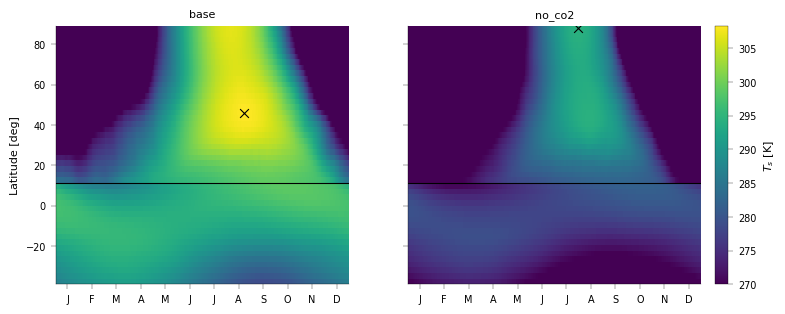

In [313]:
fig, ax = plt.subplots(1, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_exp)
for i in range(n_exp):
    im = ax[i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].t_surf.transpose(), vmin=270, vmax=ds[0].t_surf.max())
    var = get_extrema_coordinates(ds[i].t_surf, 'max')
    print(exp_name[i], var)
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_s$ [K]')
# im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].t_surf.transpose(), vmin=-40, vmax=40, cmap='bwr')
# fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_s$ [K]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_name[i])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

## Surface Fluxes
Here, we do a sanity check that our computations of surface fluxes match the simulated values well. Note that I ignore the variation in surface pressure in all of these, for simplicity.
### Latent Heat
There is a non-zero error, but this is likely because we are doing the calculation from the averaged quantities, not doing the computation first and then averaging. The magnitude of the error increases as the size of the flux increases.

In [314]:
def get_latent_heat(temp_surf, temp_diseqb, rh, evap_fraction=1, p_surf=p_surface_approx, wind_speed=w_atm_const,
                    drag_coef=drag_const, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf * sigma
    temp_a = temp_surf - temp_diseqb
    sphum_a = rh * sphum_sat(temp_a, p_a)
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return evap_fraction * L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

In [315]:
def get_humidity_from_latent_heat(flux_lhe, temp_surf, temp_diseqb, evap_fraction=1, p_surf=p_surface_approx, wind_speed=w_atm_const,
                            drag_coef=drag_const, sigma=sigma_near_surf):
    p_a = p_surf * sigma
    temp_a = temp_surf - temp_diseqb
    rho = get_density(temp_a, p_a)
    flux_lhe_rh1 = get_latent_heat(temp_surf, temp_diseqb, 1, evap_fraction, p_surf, wind_speed, drag_coef, sigma, virtual=False)
    rh = (flux_lhe_rh1 - flux_lhe) / (evap_fraction * L_v * drag_coef * rho * wind_speed * sphum_sat(temp_a, p_a)) + 1
    rh = np.clip(rh, 0, 3)          # avoid ridiculous values of rh
    sphum = rh * sphum_sat(temp_a, p_surf)
    return rh, sphum

#### RH Computation
There is a clear difference in the magnitude of the relative humidity computed from specific humidity compared to that directly computed from latent heat. Going foreward, we use the LH value as we are interested in surface temperature tendency.

In [316]:
for i in range(n_exp):
    ds[i]['rh_from_lh'], ds[i]['sphum_from_lh'] = get_humidity_from_latent_heat(ds[i].flux_lhe, ds[i].t_surf, ds[i].temp_diseqb, ds[i].evap_frac)

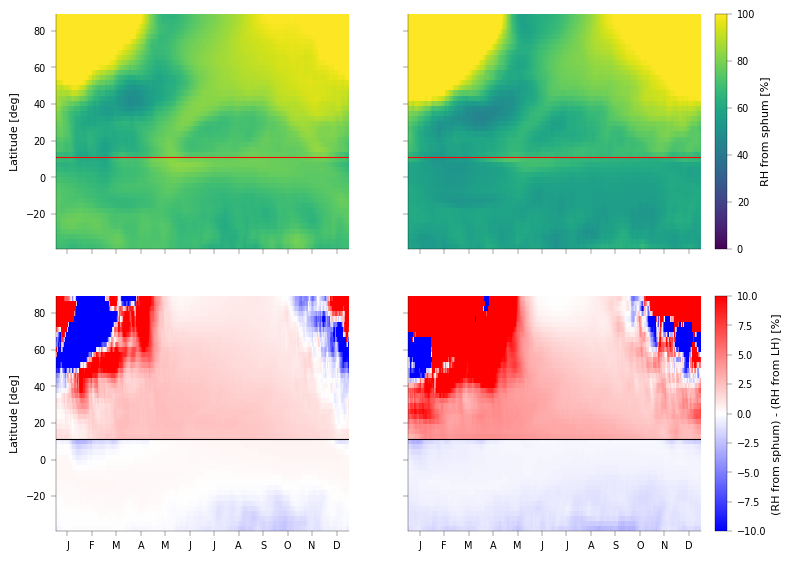

In [317]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i in range(n_exp):
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].rh.transpose()*100, vmin=0, vmax=100)
    if i == 1:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='RH from sphum [%]')
    var = ds[i].rh.transpose() - ds[i].rh_from_lh.transpose()
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, var*100, vmin=-10, vmax=10, cmap='bwr')
    if i == 1:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='(RH from sphum) - (RH from LH) [%]')
    ax[0, i].axhline(lat_land_min, color='r')
    ax[1, i].axhline(lat_land_min, color='k')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

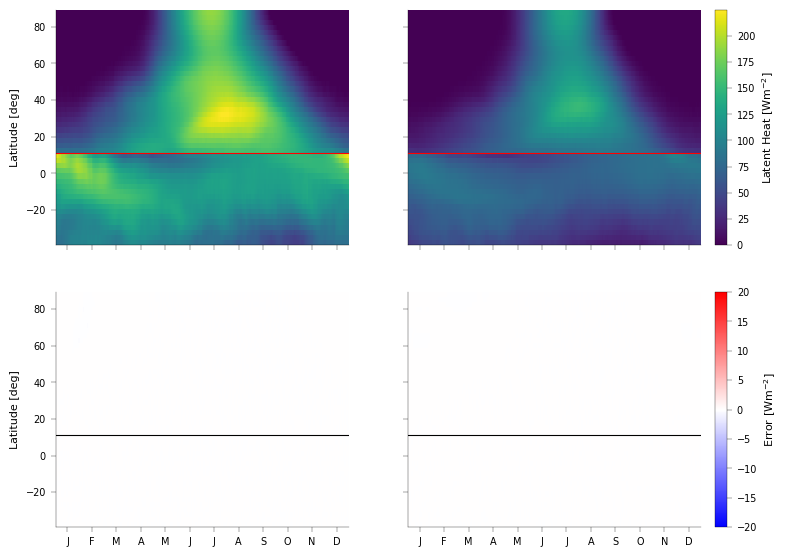

In [318]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i in range(n_exp):
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].flux_lhe.transpose(), vmin=0, vmax=ds[0].flux_lhe.max())
    if i == 1:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Latent Heat [Wm$^{-2}$]')
    var = get_latent_heat(ds[i].t_surf, ds[i].temp_diseqb, ds[i].rh_from_lh, ds[i].evap_frac)
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].flux_lhe.transpose()-var.transpose(), vmin=-20, vmax=20, cmap='bwr')
    if i == 1:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Error [Wm$^{-2}$]')
    ax[0, i].axhline(lat_land_min, color='r')
    ax[1, i].axhline(lat_land_min, color='k')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

#### RH and Precipitation correlation
It is clear that heavy precipitation due to migration of ITCZ over land suppresses relative humidity over land. Such that the hottest location is pushed just north of the ITCZ, where the RH is large again.

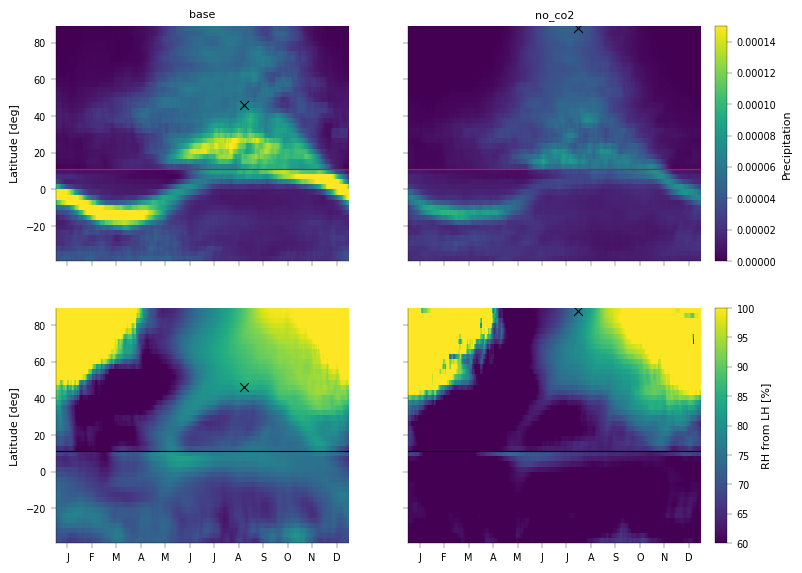

In [345]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i in range(n_exp):
    ax[0, i].set_title(exp_name[i])
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].precipitation.transpose(), vmin=0, vmax=1.5e-4)
    if i == 1:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Precipitation')
    var = ds[i].rh_from_lh.transpose()
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, var*100, vmin=60, vmax=100)
    if i == 1:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='RH from LH [%]')
    ax[0, i].axhline(lat_land_min, color='r')
    ax[1, i].axhline(lat_land_min, color='k')
    var = get_extrema_coordinates(ds[i].t_surf, 'max')
    ax[0, i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
    ax[1, i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

### Sensible Heat
The calculation for sensible heat is very close to the simulated.

In [320]:
def get_sensible_heat(temp_surf, temp_diseqb, p_surf=p_surface_approx, wind_speed=w_atm_const, drag_coef=drag_const,
                      sigma=sigma_near_surf, virtual=False, rh=None):
    p_a = p_surf * sigma
    temp_a = temp_surf - temp_diseqb
    if virtual:
        sphum_a = rh * sphum_sat(temp_a, p_a)
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return c_p * drag_coef * rho * wind_speed * (temp_surf * (1 - sigma ** (-kappa)) + temp_diseqb * sigma ** (-kappa))

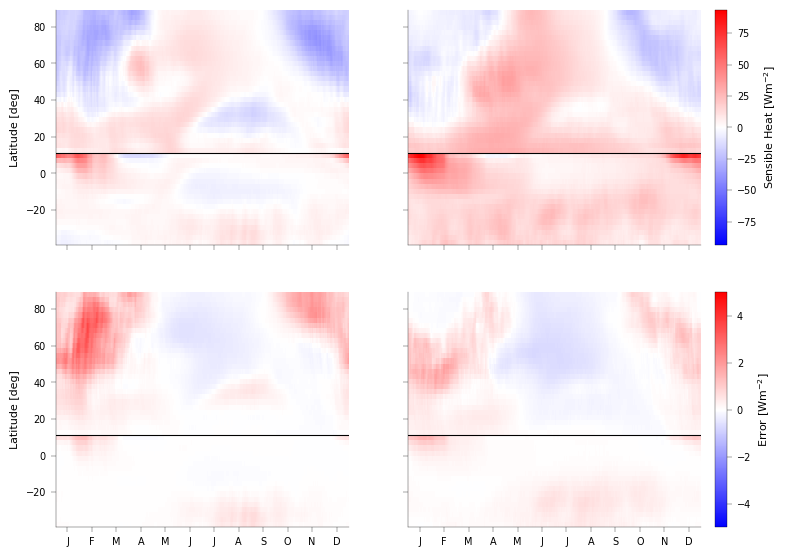

In [321]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i in range(n_exp):
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].flux_t.transpose(), vmin=-ds[-1].flux_t.max(), vmax=ds[-1].flux_t.max(), cmap='bwr')
    if i == 1:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Sensible Heat [Wm$^{-2}$]')
    var = get_sensible_heat(ds[i].t_surf, ds[i].temp_diseqb)
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].flux_t.transpose()-var.transpose(), vmin=-5, vmax=5, cmap='bwr')
    if i == 1:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Error [Wm$^{-2}$]')
    ax[0, i].axhline(lat_land_min, color='k')
    ax[1, i].axhline(lat_land_min, color='k')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

### Longwave - Brutsaert Empirical Fitting
There is an existing fitting of downward longwave radiation from near-surface water content, which is rooted in physics and [works well for observations](https://esd.copernicus.org/articles/14/1363/2023/) in clear-sky conditions, which comes from Brutsaert (1975):

$$LW^{\downarrow} = 1.24(e_a/T_a)^{1/7}\sigma T_a^4$$
where $e_a$ is the water vapour partial pressure at the lowest model level. Below, we see that this also works pretty well for the SOCRATES simulation.

It is apparent that at low temperatures e.g. winter at the poles, that this fitting underestimates the simulated flux.

In [322]:
def get_lwdn_sfc_brutsaert(temp_surf, temp_diseqb, sphum=None, rh=None, p_surf=p_surface_approx,
                           sigma=sigma_near_surf):
    p_a = p_surf * sigma
    temp_a = temp_surf - temp_diseqb
    if sphum is None:
        sphum = rh * sphum_sat(temp_a, p_a)
    wv_pressure = partial_pressure_from_sphum(sphum, p_a) * 0.01  # in units of hPa for this fit
    emissivitity = 1.24 * (wv_pressure / temp_a) ** (1 / 7)
    return emissivitity * Stefan_Boltzmann * temp_a ** 4

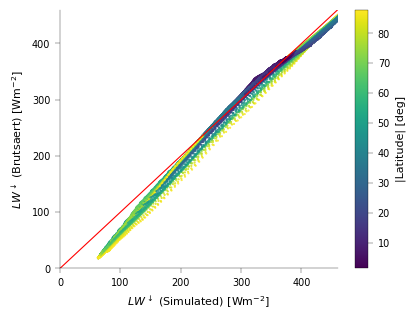

In [323]:
i=0
var2 = get_lwdn_sfc_brutsaert(ds[i].t_surf, ds[i].temp_diseqb, sphum=ds[i].sphum_from_lh)
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'])
im = ax.scatter(ds[i].lwdn_sfc, var2, marker='.', alpha=1, c=ds[i].swdn_sfc*0+np.abs(ds[i].lat), s=1)
fig.colorbar(im, ax=ax, label='|Latitude| [deg]')
ax.plot([0, 500], [0, 500], color='r')
ax.set_xlim(0, 460)
ax.set_ylim(0, 460)
ax.set_xlabel('$LW^{\downarrow}$ (Simulated) [Wm$^{-2}$]')
ax.set_ylabel('$LW^{\downarrow}$ (Brutsaert) [Wm$^{-2}$]')
plt.show()

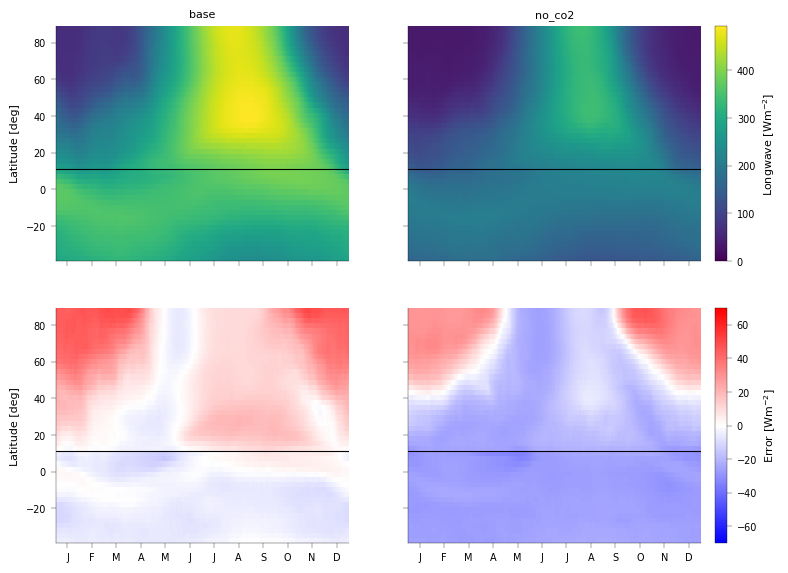

In [324]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * n_exp)
for i in range(n_exp):
    ax[0, i].set_title(exp_name[i])
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].lwdn_sfc.transpose(), vmin=0, vmax=ds[0].lwdn_sfc.max())
    if i == 1:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Longwave [Wm$^{-2}$]')
    var = get_lwdn_sfc_brutsaert(ds[i].t_surf, ds[i].temp_diseqb, rh=ds[i].rh_from_lh)
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].lwdn_sfc.transpose()-var.transpose(), vmin=-70, vmax=70, cmap='bwr')
    if i == 1:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Error [Wm$^{-2}$]')
    ax[0, i].axhline(lat_land_min, color='k')
    ax[1, i].axhline(lat_land_min, color='k')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

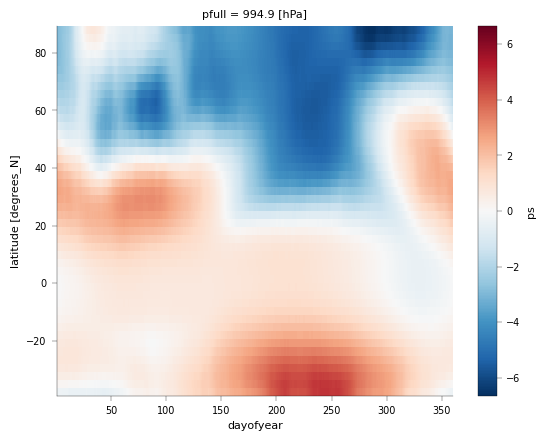

In [325]:
# Plot % variation in surface pressure to highlight that it does vary in the dynamical simulation
(100*(ds[0].ps.transpose()-p_surface_approx)/p_surface_approx).plot()

### Shortwave - Zillman Empirical Fit
The [equation](https://www.mdpi.com/2072-4292/5/10/4735?) of Zillman for $SW^{\downarrow}$ (net incoming to surface, taking account of albedo) is given by:

$SW^{\downarrow} = \frac{\cos\theta_z}{\chi_1 \cos \theta_z + 0.1e_a (\chi_2 + \cos \theta_z) + \chi_3} SW^{\downarrow}_{TOA}$

where:
* $\cos \theta_z$ is the cosine of the zenith angle
* $SW^{\downarrow}_{TOA} = S_0 \cos \theta_z$ is the incoming radiation at the top of the atmosphere
* $e_a$ is the water vapour partial pressure at the lowest model level
* $\chi_1 = 1.085$ is an empirical parameter
* $\chi_2 = 2.7$ is an empirical parameter
* $\chi_3 = 0.1$ is an empirical parameter

Below, we find the empirical parameters most appropriate for the socrates dataset. These are obviously going to be different, as here we have a surface albedo of 0.31 everywhere, whereas this varies spatially, and we don't know the actual value in the real world.

It is clear that the Zillman fitting over-estimates the shortwave radiation at the high latitudes, especially in the summer.

It is apparent that even in the case with no evaporation, the incoming radiation from longwave exceeds that from shortwave, even at the north pole. Thus, we do not expect the hottest location to be where there is most sunlight, but broadly where the combination of longwave and shortwave reaching the surface is maximised (almost exactly the case for evap=0 as latent heat is zero).

In [326]:
def combine_flatten_var(ds, var_name):
    return np.concatenate([ds[i][var_name].to_numpy().flatten() for i in range(len(ds))])

def get_swdn_sfc_zillman(swdn_toa, coszen, sphum, param1=1.085, param2=2.7, param3=0.1, p_surf=p_surface_approx, sigma=sigma_near_surf):
    p_a = p_surf * sigma
    wv_pressure = partial_pressure_from_sphum(sphum, p_a) / 1000        # in units of kPa for this fit
    # wv_pressure = 0
    prefactor = coszen / (param1 * coszen + wv_pressure * (param2+coszen)*0.1+param3)
    return prefactor * swdn_toa

def zillman_fit(X, param1, param2, param3):
    swdn_toa, coszen, sphum = X
    return get_swdn_sfc_zillman(swdn_toa, coszen, sphum, param1, param2, param3)

i = 0
zillman_param = [scipy.optimize.curve_fit(zillman_fit, np.vstack((ds[i].swdn_toa.to_numpy().flatten(), ds[i].soc_coszen.to_numpy().flatten(),
                                                                 ds[i].sphum_from_lh.to_numpy().flatten())), ds[i].swdn_sfc.to_numpy().flatten())[0]
                 for i in range(n_exp)]
zillman_param = np.asarray(zillman_param)
print(zillman_param)

[[1.64795327 0.00637453 0.03241691]
 [1.67789108 0.28747284 0.01962256]]


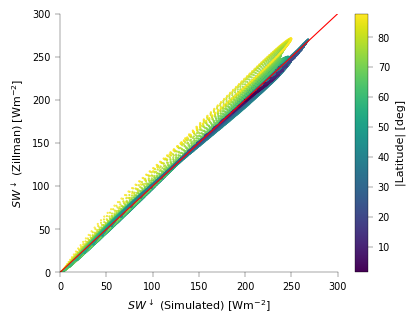

In [327]:
i=0
var2 = get_swdn_sfc_zillman(ds[i].swdn_toa, ds[i].soc_coszen, ds[i].sphum_from_lh, zillman_param[i, 0],
                           zillman_param[i, 1], zillman_param[i, 2])
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'])
im = ax.scatter(ds[i].swdn_sfc, var2, marker='.', alpha=1, c=ds[i].swdn_sfc*0+np.abs(ds[i].lat), s=1)
fig.colorbar(im, ax=ax, label='|Latitude| [deg]')
ax.plot([0, 500], [0, 500], color='r')
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
ax.set_xlabel('$SW^{\downarrow}$ (Simulated) [Wm$^{-2}$]')
ax.set_ylabel('$SW^{\downarrow}$ (Zillman) [Wm$^{-2}$]')
plt.show()

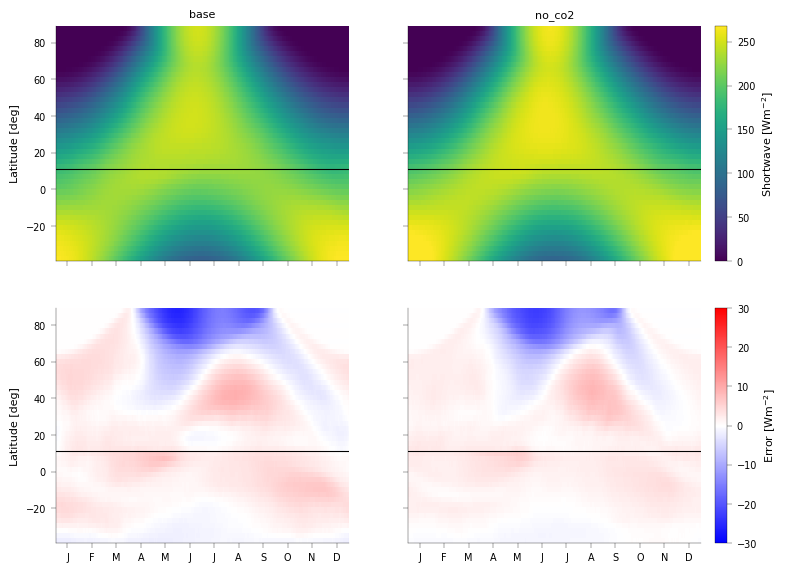

In [328]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * n_exp)
for i in range(n_exp):
    var = get_swdn_sfc_zillman(ds[i].swdn_toa, ds[i].soc_coszen, ds[i].sphum_from_lh, zillman_param[i, 0],
                           zillman_param[i, 1], zillman_param[i, 2])
    ax[0, i].set_title(exp_name[i])
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].swdn_sfc.transpose(), vmin=0, vmax=ds[0].swdn_sfc.max())
    if i == 1:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Shortwave [Wm$^{-2}$]')
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].swdn_sfc.transpose()-var.transpose(), vmin=-30, vmax=30, cmap='bwr')
    if i == 1:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Error [Wm$^{-2}$]')
    ax[0, i].axhline(lat_land_min, color='k')
    ax[1, i].axhline(lat_land_min, color='k')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

### Temperature tendency
The theoretical temperature tendency clearly does not match the actual temperature tendency, so this is problematic for estimating the maximum temperature and where it occurs.

In [346]:
try:
    rh_const = const_params['rh_from_lh']
except:
    rh_const = 0.724656375616225            # value for base simulation
def get_temp_tendency(temp_surf, swdn_toa, coszen, temp_diseqb,
                      rh, heat_capacity, p_surf=p_surface_approx, wind_speed=w_atm_const,
                      drag_q=drag_const, sigma=sigma_near_surf,
                      zillman_empirical_param=zillman_param[0], evap_fraction=1,
                      swdn_sfc_residual=0, lwdn_sfc_residual=0, rh_effect='all'):
    # Include residuals to allow for error in empirical fitting
    lwup_sfc = Stefan_Boltzmann * temp_surf**4
    lwdn_sfc = get_lwdn_sfc_brutsaert(temp_surf, temp_diseqb, rh=rh if rh_effect in ['all', 'lw'] else rh_const,
                                      p_surf=p_surf, sigma=sigma) + lwdn_sfc_residual
    lhup = get_latent_heat(temp_surf, temp_diseqb, rh if rh_effect in ['all', 'lh'] else rh_const,
                           evap_fraction, p_surf, wind_speed, drag_q, sigma, virtual=False)
    shup = get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_q, sigma, virtual=False)
    temp_a = temp_surf - temp_diseqb
    sphum_a = (rh if rh_effect in ['all', 'sw'] else rh_const) * sphum_sat(temp_a, sigma * p_surf)
    swdn_sfc = get_swdn_sfc_zillman(swdn_toa, coszen, sphum_a, zillman_empirical_param[0], zillman_empirical_param[1], zillman_empirical_param[2],
                                    p_surf, sigma) + swdn_sfc_residual
    # swdn_sfc = ds[0].swdn_sfc
    # lwdn_sfc = ds[0].lwdn_sfc
    return (swdn_sfc + lwdn_sfc - lwup_sfc - lhup - shup)/heat_capacity

{'dayofyear': 232, 'lat': 46.044726631101675, 'extrema_value': 308.3549}
{'dayofyear': 209, 'lat': 87.86379883923264, 'extrema_value': 294.38766}


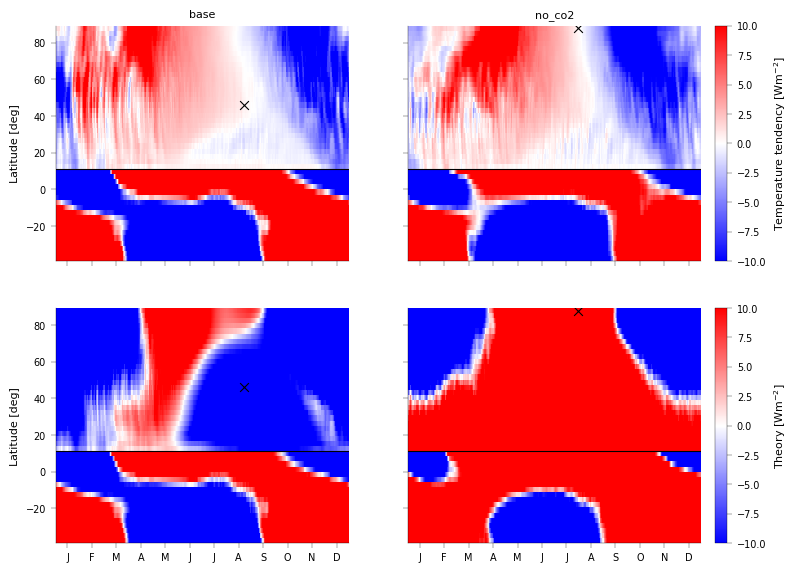

In [330]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * n_exp)
for i in range(n_exp):
    ax[0, i].set_title(exp_name[i])
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].flux_sfc_dn_net.transpose(), vmin=-10, vmax=10, cmap='bwr')
    if i == n_exp-1:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Temperature tendency [Wm$^{-2}$]')
    var = get_temp_tendency(ds[i].t_surf, ds[i].swdn_toa, ds[i].soc_coszen, ds[i].temp_diseqb, ds[i].rh_from_lh,
                            ds[i].heat_capacity, evap_fraction=ds[i].evap_frac) * ds[i].heat_capacity
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, var.transpose(), vmin=-10, vmax=10, cmap='bwr')
    if i == n_exp-1:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Theory [Wm$^{-2}$]')
    ax[0, i].axhline(lat_land_min, color='k')
    ax[1, i].axhline(lat_land_min, color='k')
    var = get_extrema_coordinates(ds[i].t_surf, 'max')
    print(var)
    ax[0, i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
    ax[1, i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

### Latitudinal variation in temperature
Below we see that on a given day, the latitudinal variation is much larger over land for zero evaporation.

It is also interesting that the ocean in the southern hemisphere is colder for zero land evaporation, despite there being no change to the ocean between the simulations. This maybe because there is less moisture over the ocean, simply because less is advected from over land. Thus, there is less downward longwave radiation reaching the surface.

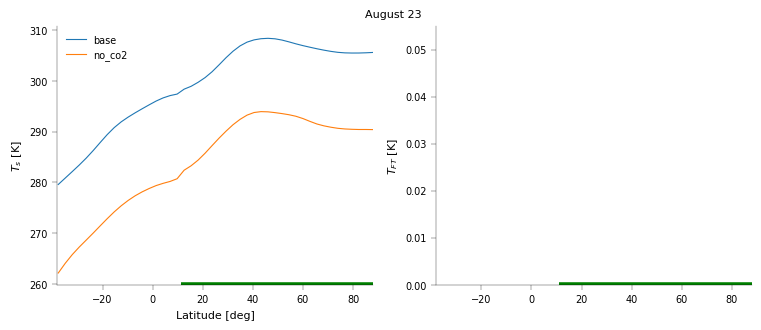

In [331]:
def get_month_day_from_ind(day_index):
    month = day_index // 30 + 1  # +1 for 1-based month
    day = day_index % 30 + 1     # +1 for 1-based day
    return month, day

linestyle_exp = ['-', '--', ':']
fig, ax = plt.subplots(1, 2, sharex=True)
isca_tools.plot.fig_resize(fig, 2*im_sz*width['one_col'])
day_plot = get_extrema_coordinates(ds[0].t_surf, 'max')['dayofyear']
for i in range(n_exp):
    # for j in range(n_exp):
    ax[0].plot(ds[i].lat, ds[i].t_surf.isel(dayofyear=day_plot), color=color_exp[i],
            label=exp_name[i])
    # ax[0].plot(ds[i].lat, temp_surf_eqb_day[i], color=color_exp[i], linestyle=':')
    # ax[1].plot(ds[i].lat, ds[i].temp.isel(dayofyear=day_plot, pfull=ind_ft), color=color_exp[i])
ax[0].legend()
ax[0].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('$T_s$ [K]')
ax[1].set_ylabel('$T_{FT}$ [K]')
ax[0].set_xlim(ax_lims_lat)
var = get_month_day_from_ind(day_plot)
label_use = f'{calendar.month_name[var[0]]} {var[1]}'
fig.suptitle(label_use, fontsize=8, y=0.93)
show_land(ax)
plt.show()

### Seasonal variation of RH and $T_{diseqb}$
Below, we look at a single latitude, and plot the variation throughout the year of relative humidity and disequilibrium temperature. The idea being, that both of these variables enter the surface energy budget.

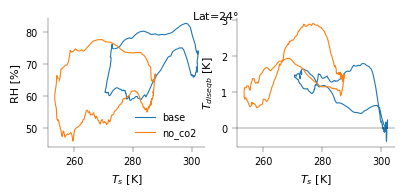

In [332]:
fig, ax = plt.subplots(1, 2, sharex=True)
isca_tools.plot.fig_resize(fig, 1*im_sz*width['one_col'])
for lat_plot_ind in [22]:
    for i in range(n_exp):
        ax[0].plot(ds[i].t_surf.isel(lat=lat_plot_ind), ds[i].rh_from_lh.isel(lat=lat_plot_ind)*100, label=exp_name[i], color=color_exp[i])
        # ax[0].plot(ds[i].t_surf.isel(lat=lat_plot_ind), ds[i].sphum.isel(lat=lat_plot_ind, pfull=ind_surf)*1000, label=exp_name[i], color=color_exp[i])
        ax[1].plot(ds[i].t_surf.isel(lat=lat_plot_ind), ds[i].temp_diseqb.isel(lat=lat_plot_ind), color=color_exp[i])
        # ax[2].plot(ds[i].t_surf.isel(lat=lat_plot_ind), ds[i].temp_diseqb_rad.isel(lat=lat_plot_ind), color=color_exp[i])
# ax.plot(ds_dyn.t_surf.isel(lat=lat_plot_ind), ds_dyn.temp_diseqb.isel(lat=lat_plot_ind), label='Gray (dynamic)', color='k')
ax[0].set_xlabel('$T_s$ [K]')
ax[0].set_ylabel('RH [%]')
ax[1].set_xlabel('$T_s$ [K]')
ax[1].set_ylabel('$T_{diseqb}$ [K]')
ax[0].legend()
# ax[0].set_ylim(0, ax[0].get_ylim()[1])
ax[1].axhline(0, color='k', lw=ax_linewidth)
fig.suptitle(f'Lat={ds[0].lat[lat_plot_ind].values:.0f}$\degree$', fontsize=8, y=0.93)
plt.show()

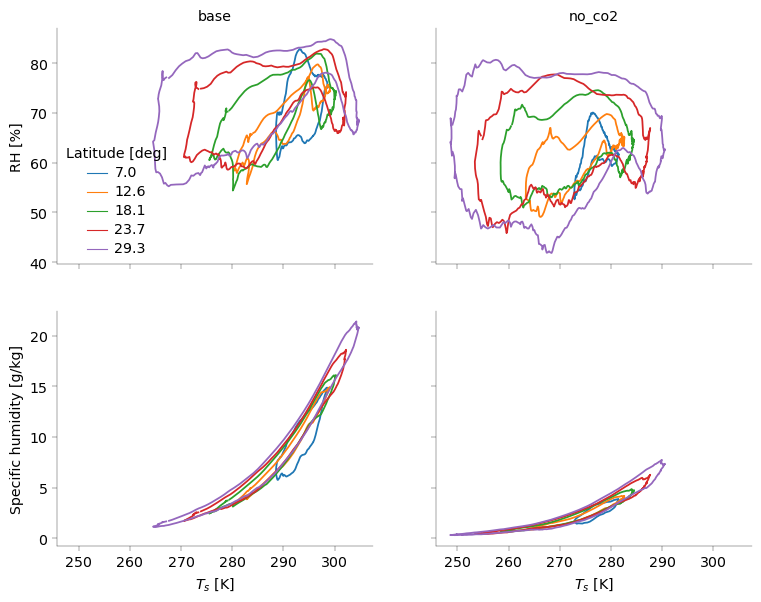

In [333]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey='row')
isca_tools.plot.fig_resize(fig, 2*im_sz*width['one_col'])
lat_plot_ind = np.arange(16, 26, 2)
for i in range(n_exp):
    ax[0, i].set_title(exp_name[i])
    for j in range(len(lat_plot_ind)):
        ds_use = ds[i].isel(lat=lat_plot_ind[j])[['rh_from_lh', 'sphum_from_lh', 't_surf']]
        ax[0, i].plot(ds_use.t_surf, ds_use.rh_from_lh*100, label=f"{ds_use.lat:.1f}", color=f"C{j}")
        # ax[0].plot(ds[i].t_surf.isel(lat=lat_plot_ind), ds[i].sphum.isel(lat=lat_plot_ind, pfull=ind_surf)*1000, label=exp_name[i], color=color_exp[i])
        ax[1, i].plot(ds_use.t_surf, ds_use.sphum_from_lh*1000, color=f"C{j}")
ax[1, 0].set_xlabel('$T_s$ [K]')
ax[1, 1].set_xlabel('$T_s$ [K]')
ax[0, 0].set_ylabel('RH [%]')
ax[1, 0].set_ylabel('Specific humidity [g/kg]')
# ax[1].set_xlabel('$T_s$ [K]')
# ax[1].set_ylabel('Specific humidity [g/kg]')
# # ax[2].set_ylabel('$T_{diseqb, rad}$ [K]')
ax[0, 0].legend(title='Latitude [deg]')
# ax[1, 0].set_yscale('log')
# ax[1].legend(title='Latitude')
isca_tools.plot.update_linewidth(fig)
isca_tools.plot.update_fontsize(fig)
# ax[0].set_ylim(0, ax[0].get_ylim()[1])
plt.show()

## Hottest Day as function of latitude
Below, we see that the theoretical net flux into the surface is not zero on the hottest day. This means that the hottest day of the year as a function of latitude, using this theoretical framework for temperature tendency is not particularly good.

The main issue is at high latitudes, where the estimates of the LW, LH and SH are over-estimated I think. There is a clear correspondence between the over-estimate in net flux, and the temperature over-estimate in the left plot.

The evap=0 situation is more complicated, when we can't even get a prediction because (I think) the temperature tendency is always positive i.e. a runaway greenhouse type effect.

In [334]:
# Get dataset conditioned on the hottest day
ds_hottest = []
for i in range(n_exp):
    ds_hottest.append([ds[i].isel(lat=j, dayofyear=ds[i].t_surf.isel(lat=j).argmax()) for j in range(n_lat)])
    ds_hottest[i] = xr.concat(ds_hottest[i], dim='lat')
    ds_hottest[i]['flux_lhe_theory'] = get_latent_heat(ds_hottest[i].t_surf, ds_hottest[i].temp_diseqb, ds_hottest[i].rh_from_lh, ds_hottest[i].evap_frac)
    ds_hottest[i]['flux_t_theory'] = get_sensible_heat(ds_hottest[i].t_surf, ds_hottest[i].temp_diseqb)
    ds_hottest[i]['lwdn_sfc_theory'] = get_lwdn_sfc_brutsaert(ds_hottest[i].t_surf, ds_hottest[i].temp_diseqb, rh=ds_hottest[i].rh_from_lh)
    ds_hottest[i]['lwup_sfc_theory'] = Stefan_Boltzmann * ds_hottest[i].t_surf**4
    ds_hottest[i]['swdn_sfc_theory'] = get_swdn_sfc_zillman(ds_hottest[i].swdn_toa, ds_hottest[i].soc_coszen, ds_hottest[i].sphum_from_lh,
                                                            zillman_param[i, 0], zillman_param[i, 1], zillman_param[i, 2])

### Surface fluxes and estimates on hottest day
Plot how the surface fluxes vary with latitude on the hottest day.

We see that the hottest day occurs just after the minima in latent heat flux, because when latent heat is at a minima, it dominates the cooling, so there must be less cooling coming from the Plank feedback i.e. due to large temperature.

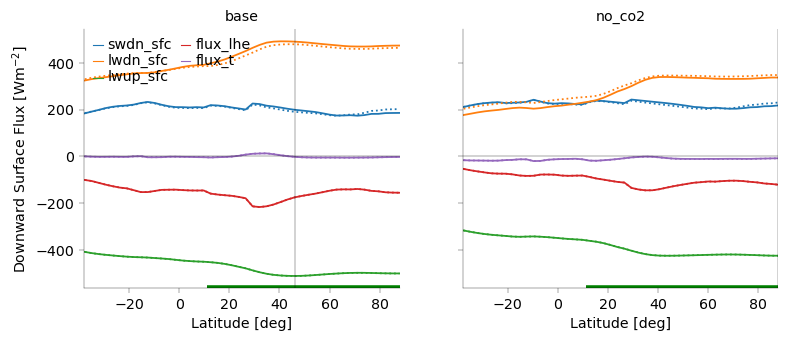

In [335]:
fig, ax = plt.subplots(1, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_exp)
for i in range(n_exp):
    ax[i].set_title(exp_name[i])
    for j, key in enumerate(['swdn_sfc', 'lwdn_sfc', 'lwup_sfc', 'flux_lhe', 'flux_t']):
        ax[i].plot(ds_hottest[i].lat, ds_hottest[i][key] * (-1 if 'dn' not in key else 1), label=key)
        ax[i].plot(ds_hottest[i].lat, ds_hottest[i][key+'_theory'] * (-1 if 'dn' not in key else 1), linestyle=':', color=f"C{j}")
    #  ax[i].plot(ds_hottest[i].lat, ds_hottest[i]['lwdn_sfc'] - ds_hottest[i]['lwup_sfc'], color='k', label='lwdn_net')
# ax[0].legend(ncol=2)
add_legend(ax[0], ncol=2)
ax[0].set_xlim(ax_lims_lat)
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
isca_tools.plot.update_fontsize(fig)
show_land(ax)
isca_tools.plot.update_linewidth(fig)
for i in range(n_exp):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].axvline(get_extrema_coordinates(ds[i].t_surf)['lat'], color='k', lw=ax_linewidth)
ax[0].set_ylabel('Downward Surface Flux [Wm$^{-2}$]')
plt.show()

### Effect of Parameters
Above we see, when we take the parameters at the time of maximum surface temperature at each latitude, then the hottest location is in subtropics, not the pole. This is despite the pole having the most insolation. Below we explore which parameters are the major factor in this. I.e. which parameters can explain why the dotted and dashed orange lines above differ.

I neglect the drag here, as I think as the wind is constant, it would make sense to impose it as a constant i.e. re-run the simulations. Also, hard to interpret. Without it, just have three parameters: insolation, relative humidity and surface - air temperature disequilibrium.

Below I plot the latitudinal variation in parameters on the hottest day at each latitude.

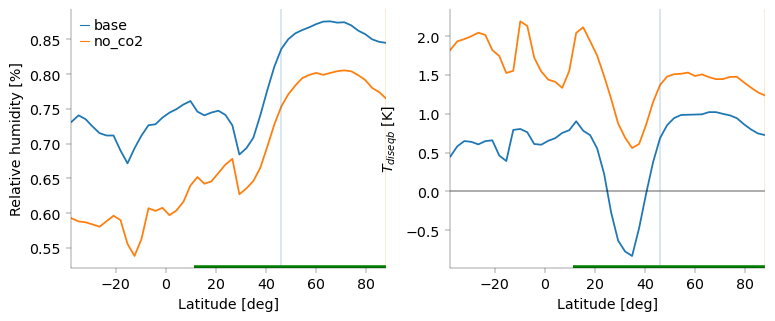

In [336]:
fig, ax = plt.subplots(1, 2, sharex=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_exp)
for i in range(n_exp):
    ax[0].plot(ds[i].lat, ds_hottest[i].rh_from_lh, label=exp_name[i], color=f"C{i}")
    ax[1].plot(ds[i].lat, ds_hottest[i].temp_diseqb, color=f"C{i}")
    # ax[1].plot(ds[key].lat, [ds[key].temp_diseqb.isel(lat=i, dayofyear=ds[key].t_surf.isel(lat=i).argmax()) for i in range(n_lat)],
    #            label='$T_{diseqb}$' if key=='gray' else None)
# ax[1].plot(ds['gray'].lat, [ds['gray'].temp_diseqb_rad_gray.isel(lat=i, dayofyear=ds[key].t_surf.isel(lat=i).argmax()) for i in range(n_lat)],
#            color=color_exp['gray'], linestyle='--', label='$T_{diseqb,r}$')
# ax[0].plot(ds[key].lat, [ds_dyn.rh.isel(lat=i, dayofyear=ds_dyn.t_surf.isel(lat=i).argmax())*100 for i in range(n_lat)], color='k')
ax[0].set_ylabel('Relative humidity [%]')
ax[1].set_ylabel('$T_{diseqb}$ [K]')
add_legend(ax[0])
ax[0].set_xlim(ax_lims_lat)
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
isca_tools.plot.update_fontsize(fig)
show_land(ax)
isca_tools.plot.update_linewidth(fig)
for i in range(2):
    ax[1].axhline(0, color='k', lw=ax_linewidth)
    for j in range(n_exp):
        ax[i].axvline(get_extrema_coordinates(ds[j].t_surf)['lat'], color=f'C{j}', lw=ax_linewidth)
plt.show()

In [337]:
def find_root_with_sign_check(f, args, x0=300, epsilon=1e-3, search_step=5, max_attempts=10):
    """
    Find a root of f(x) using the secant method, starting at x0.
    Only accept root if f(x - ε) > 0 and f(x + ε) < 0. I.e. if is a maxima
    If not, search around x0 for another root.
    search_range is in kelvin

    """
    attempts = 0
    offset = 0
    while attempts < max_attempts:
        x_start = x0 + offset

        try:
            # Use secant method: requires two initial points
            res = scipy.optimize.root_scalar(f, x0=x_start, x1=x_start + 0.1, method='secant', args=args)

            if res.converged:
                x_root = res.root
                # Only return if maxima
                f_before = f(x_root - epsilon, *args)
                f_after = f(x_root + epsilon, *args)

                if f_before > 0 and f_after < 0:
                    return x_root
                # Otherwise: try next offset
        except ValueError:
            pass  # silently skip if secant fails

        # Try a new offset (symmetric search around x0)
        attempts += 1
        offset = ((attempts + 1) // 2) * search_step * (-1)**attempts
    raise RuntimeError("No suitable root found after all attempts.")

def get_temp_equilibrium(swdn_toa, coszen, temp_diseqb,
                         rh, heat_capacity, p_surf=p_surface_approx, wind_speed=w_atm_const,
                         drag_q=drag_const, sigma=sigma_near_surf,
                         zillman_empirical_param=zillman_param[0], evap_fraction=1,
                         swdn_sfc_residual=0, lwdn_sfc_residual=0, rh_effect='all', initial_guess=300):
    # Solve for temp tendency equals zero to get equilibrium temperature
    var = find_root_with_sign_check(get_temp_tendency, args=(swdn_toa, coszen, temp_diseqb, rh, heat_capacity, p_surf, wind_speed, drag_q, sigma,
                                                             zillman_empirical_param, evap_fraction, swdn_sfc_residual, lwdn_sfc_residual, rh_effect),
                                    x0=initial_guess)
    return var

In [338]:
temp_surf_eqb_hottest = np.full((n_exp, n_lat), np.nan)
pbar = tqdm(total=n_exp*n_lat)
for i in range(n_exp):
    for j in range(n_lat):
        try:
            temp_surf_eqb_hottest[i, j] = get_temp_equilibrium(ds_hottest[i].isel(lat=j).swdn_toa, ds_hottest[i].isel(lat=j).soc_coszen,
                                                               ds_hottest[i].isel(lat=j).temp_diseqb, ds_hottest[i].isel(lat=j).rh_from_lh,
                                                               ds_hottest[i].isel(lat=j).heat_capacity,
                                                               evap_fraction=ds_hottest[i].isel(lat=j).evap_frac,
                                                               zillman_empirical_param=zillman_param[i])
            # temp_surf_eqb_hottest[i, j] = get_temp_equilibrium(ds_use.swdn_sfc, ds_use.temp_diseqb, ds_use.temp_diseqb_rad, opd_lw_gray(ds_use.lat),
            #                                                    ds_use.rh_from_lh, ds_use.heat_capacity, evap_fraction=ds_use.evap_frac)
        except RuntimeError as var:
            print(exp_name[i], f"lat={ds_use.lat:.0f}", var)
        pbar.update(1)
    ds_hottest[i]['t_surf_theory'] = xr.DataArray(temp_surf_eqb_hottest[i], coords=[ds_hottest[i].lat])

  0%|          | 0/92 [00:00<?, ?it/s]

In [339]:
def get_land_median_var(ds, var, lat_min=lat_land_min, lat_max=50):
    return float(ds[var].sel(lat=slice(lat_min, lat_max)).median())
# Compute average value of parameters from both experiments combined
const_params = {var: np.mean([get_land_median_var(ds[i], var) for i in range(n_exp-1)])
                for var in ['rh_from_lh', 'temp_diseqb', 'swdn_toa', 'soc_coszen']}
const_params

{'rh_from_lh': 0.7246563756162248,
 'temp_diseqb': 0.6293655633926392,
 'swdn_toa': 377.70635986328125,
 'soc_coszen': 0.2777251601219177}

### Effect of Parameters
Above we see, when we take the parameters at the time of maximum surface temperature at each latitude, then the hottest location is in subtropics, not the pole. This is despite the pole having the most insolation. Below we explore which parameters are the major factor in this. I.e. which parameters can explain why the dotted and dashed orange lines above differ.

I neglect the drag here, as I think as the wind is constant, it would make sense to impose it as a constant i.e. re-run the simulations. Also, hard to interpret. Without it, just have three parameters: insolation, relative humidity and surface - air temperature disequilibrium.

Below I plot the latitudinal variation in parameters on the hottest day at each latitude.

In [348]:
temp_max_ref = get_temp_equilibrium(const_params['swdn_toa'], const_params['soc_coszen'], const_params['temp_diseqb'], const_params['rh_from_lh'],
                                    float(ds[0].heat_capacity.isel(lat=0, dayofyear=0)),
                                    evap_fraction=float(ds[0].evap_frac.isel(lat=0, dayofyear=0)))

In [349]:
temp_max_ref = get_temp_equilibrium(const_params['swdn_toa'], const_params['soc_coszen'], const_params['temp_diseqb'], const_params['rh_from_lh'],
                                    float(ds[0].heat_capacity.isel(lat=0, dayofyear=0)),
                                    evap_fraction=float(ds[0].evap_frac.isel(lat=0, dayofyear=0)))
temp_eqb_param = {key: np.zeros((n_exp, n_lat)) for key in ['swdn_toa', 'rh', 'temp_diseqb', 'swdn_sfc_residual',
                                                            'lwdn_sfc_residual', 'rh_lh', 'rh_lw', 'rh_sw']}
with tqdm(total=n_exp*n_lat) as pbar:
    for i in range(n_exp):
        for j in range(n_lat):
            ds_use = ds_hottest[i].isel(lat=j)
            temp_eqb_param['swdn_toa'][i, j] = get_temp_equilibrium(ds_use['swdn_toa'], ds_use['soc_coszen'],
                                                                    const_params['temp_diseqb'], const_params['rh_from_lh'],
                                                                    ds_use.heat_capacity, evap_fraction=ds_use.evap_frac,
                                                                    zillman_empirical_param=zillman_param[i]) - temp_max_ref
            temp_eqb_param['rh'][i, j] = get_temp_equilibrium(const_params['swdn_toa'], const_params['soc_coszen'],
                                                                      const_params['temp_diseqb'], ds_use['rh_from_lh'],
                                                                      ds_use.heat_capacity, evap_fraction=ds_use.evap_frac,
                                                                      zillman_empirical_param=zillman_param[0]) - temp_max_ref
            temp_eqb_param['temp_diseqb'][i, j] = get_temp_equilibrium(const_params['swdn_toa'], const_params['soc_coszen'],
                                                                       ds_use['temp_diseqb'], const_params['rh_from_lh'],
                                                                       ds_use.heat_capacity, evap_fraction=ds_use.evap_frac,
                                                                       zillman_empirical_param=zillman_param[0]) - temp_max_ref
            # Record error due to empirical fitting
            temp_eqb_param['swdn_sfc_residual'][i, j] = get_temp_equilibrium(const_params['swdn_toa'], const_params['soc_coszen'],
                                                                             const_params['temp_diseqb'], const_params['rh_from_lh'],
                                                                             ds_use.heat_capacity, evap_fraction=ds_use.evap_frac,
                                                                             zillman_empirical_param=zillman_param[0],
                                                                             swdn_sfc_residual=ds_use.swdn_sfc-ds_use.swdn_sfc_theory) - temp_max_ref
            temp_eqb_param['lwdn_sfc_residual'][i, j] = get_temp_equilibrium(const_params['swdn_toa'], const_params['soc_coszen'],
                                                                             const_params['temp_diseqb'], const_params['rh_from_lh'],
                                                                             ds_use.heat_capacity, evap_fraction=ds_use.evap_frac,
                                                                             zillman_empirical_param=zillman_param[0],
                                                                             lwdn_sfc_residual=ds_use.lwdn_sfc-ds_use.lwdn_sfc_theory) - temp_max_ref

            # Record separate effects of rh
            for key in ['lh', 'lw', 'sw']:
                temp_eqb_param[f'rh_{key}'][i, j] = get_temp_equilibrium(const_params['swdn_toa'], const_params['soc_coszen'],
                                                          const_params['temp_diseqb'], ds_use['rh_from_lh'],
                                                          ds_use.heat_capacity, evap_fraction=ds_use.evap_frac,
                                                          zillman_empirical_param=zillman_param[0], rh_effect=key) - temp_max_ref

            pbar.update(1)
temp_eqb_param['sum'] = sum([temp_eqb_param[key] for key in ['swdn_toa', 'rh', 'temp_diseqb']]) + temp_max_ref
temp_eqb_param['non_linear'] = temp_surf_eqb_hottest - temp_eqb_param['sum']
for i in range(n_exp):
    ds_hottest[i]['t_surf_theory_linear'] = temp_eqb_param['sum'][i]

  0%|          | 0/92 [00:00<?, ?it/s]

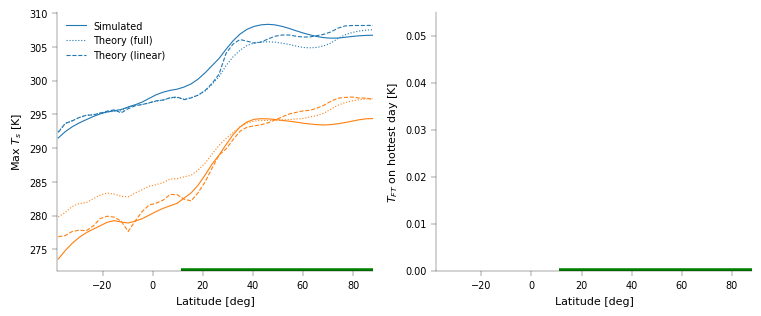

In [350]:
fig, ax = plt.subplots(1, 2, sharex=True)
isca_tools.plot.fig_resize(fig, 2*im_sz*width['one_col'])
for i in range(n_exp):
    ax[0].plot(ds[i].lat, ds_hottest[i].t_surf, color=color_exp[i], label='Simulated' if i==0 else None)
    ax[0].plot(ds[i].lat, ds_hottest[i].t_surf_theory, color=color_exp[i], linestyle=':', label='Theory (full)' if i==0 else None)
    ax[0].plot(ds[i].lat, ds_hottest[i].t_surf_theory_linear, color=color_exp[i], linestyle='--', label='Theory (linear)' if i==0 else None)
    # ax[1].plot(ds[i].lat, temp_ft_on_hottest[i], color=color_exp[i], label=exp_name[i])
    # ax[1].plot(ds[i].lat, net_flux_sfc_dn_hottest_theory[i], color=color_exp[i], linestyle=':')
# ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ax_lims_lat)
# ax[0].set_ylim(287, 317)
show_land(ax)
ax[0].legend()
# ax[1].legend()
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
ax[1].set_ylabel('$T_{FT}$ on hottest day [K]')
ax[0].set_ylabel('Max $T_s$ [K]')
plt.show()

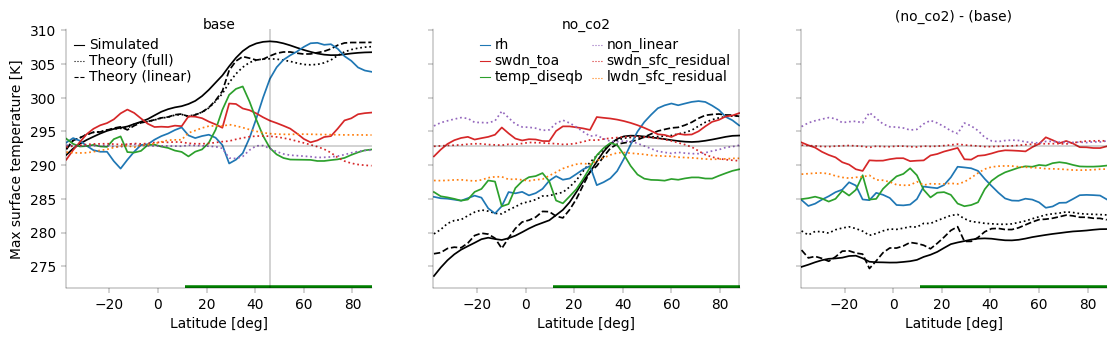

In [354]:
colors_use = {'rh': default_colors[0], 'swdn_toa': default_colors[3], 'temp_diseqb': default_colors[2], 'non_linear': default_colors[4],
              'swdn_sfc_residual': default_colors[3], 'lwdn_sfc_residual': default_colors[1], 'rh_lw': default_colors[1],
              'rh_lh': default_colors[2], 'rh_sw': default_colors[3]}
show_rh_decomp = False
linestyle_use = {key: None for key in colors_use}
linestyle_use['non_linear'] = ':'
linestyle_use['swdn_sfc_residual'] = ':'
linestyle_use['lwdn_sfc_residual'] = ':'
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i in range(n_exp):
    ax[i].set_title(exp_name[i], y=0.97)
    ax[i].plot(ds[i].lat, ds[i].t_surf.max(dim='dayofyear'), color='k', label='Simulated' if i==0 else None)
    ax[i].plot(ds[i].lat, temp_surf_eqb_hottest[i], color='k', linestyle=':', label='Theory (full)' if i==0 else None)
    ax[i].plot(ds[i].lat, temp_eqb_param['sum'][i], color='k', linestyle='--', label='Theory (linear)' if i==0 else None)
    for key in colors_use:
        if ('rh_' in key) and not show_rh_decomp:
            continue
        if ('rh' not in key) and show_rh_decomp:
            continue
        ax[i].plot(ds[i].lat, temp_eqb_param[key][i] + temp_max_ref, label=key if i==1 else None, color=colors_use[key], linestyle=linestyle_use[key])
ax[2].plot(ds[0].lat, ds[1].t_surf.max(dim='dayofyear')-ds[0].t_surf.max(dim='dayofyear')+temp_max_ref, color='k')
ax[2].plot(ds[0].lat, temp_surf_eqb_hottest[1]-temp_surf_eqb_hottest[0]+temp_max_ref, color='k', linestyle=':')
ax[2].plot(ds[0].lat, temp_eqb_param['sum'][1]-temp_eqb_param['sum'][0]+temp_max_ref, color='k', linestyle='--')
for key in colors_use:
    if ('rh_' in key) and not show_rh_decomp:
        continue
    if ('rh' not in key) and show_rh_decomp:
        continue
    ax[2].plot(ds[0].lat, temp_eqb_param[key][1]-temp_eqb_param[key][0] + temp_max_ref, color=colors_use[key], linestyle=linestyle_use[key])
ax[2].set_title(f"({exp_name[1]}) - ({exp_name[0]})")
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
ax[2].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Max surface temperature [K]')
ax[0].set_xlim(ax_lims_lat)
add_legend(ax[0], ncol=1)
add_legend(ax[1], ncol=2)
isca_tools.plot.update_fontsize(fig)
show_land(ax)
isca_tools.plot.update_linewidth(fig)
for i in range(n_exp+1):
    ax[i].axhline(temp_max_ref, color='k', lw=ax_linewidth)
    if i < n_exp:
        ax[i].axvline(get_extrema_coordinates(ds[i].t_surf)['lat'], color='k', lw=ax_linewidth)
# ax[0].set_ylim(296, 313)
plt.show()
# isca_tools.savefig(fig, 'temp_max_param')

TypeError: list indices must be integers or slices, not str

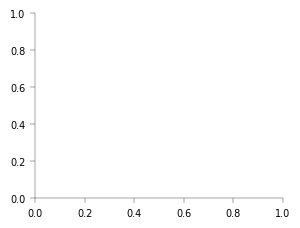

In [344]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, width['one_col'])
var_plot = ax.contour(ds['soc'].lat, rh_2d_plot*100, temp_eqb_2d['soc_rh'].transpose(), colors='black', levels=[300, 305, 310, 320])
ax.set_xlim(0, 90)
ax.clabel(var_plot, inline=True)
isca_tools.plot.update_fontsize(fig)
ax.scatter(ds['soc'].lat, [float(ds['soc'].rh.isel(lat=i, dayofyear=ds['soc'].t_surf.isel(lat=i).argmax()))*100 for i in range(n_lat)],
           marker='.', color='k', s=20)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Relative humidity [%]')
isca_tools.plot.update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig, 'soc_rh_lat.pdf')

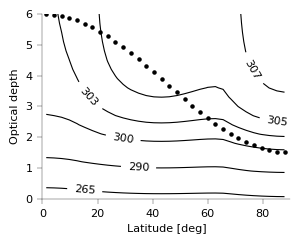

In [56]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, width['one_col'])
var_plot = ax.contour(ds['soc'].lat, opd_2d_plot, temp_eqb_2d['gray_opd_pole'].transpose(), levels=[265, 290, 300, 303, 305, 307], colors='black')
ax.clabel(var_plot, inline=True)
ax.scatter(ds['soc'].lat, opd_lw_gray(ds['soc'].lat),
           marker='.', color='k', s=20)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Optical depth')
ax.set_xlim(0, 90)
isca_tools.plot.update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig, 'gray_opd_lat.pdf')